# Results from Google Big Query: HackerNews
## https://github.com/HackerNews/API for fields definition

In [8]:
import pandas as pd

df = pd.read_csv('/Users/jing/Desktop/GA/Project_GA/hn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
by             10000 non-null object
score          10000 non-null int64
time           10000 non-null int64
title          9502 non-null object
type           10000 non-null object
url            4598 non-null object
text           10000 non-null object
parent         498 non-null float64
deleted        0 non-null float64
dead           3629 non-null object
descendants    8989 non-null float64
id             10000 non-null int64
ranking        0 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1015.7+ KB


In [9]:
print df.type.value_counts()
print df[df.parent.notnull()].head()

story      9334
pollopt     498
job         102
poll         66
Name: type, dtype: int64
              by  score        time title     type  url  \
150      davidst      0  1295598615   NaN  pollopt  NaN   
151         pyre      0  1370639741   NaN  pollopt  NaN   
152     weixiyen      0  1277926148   NaN  pollopt  NaN   
153  ColinWright     28  1365328173   NaN  pollopt  NaN   
154         jaxn      0  1296060464   NaN  pollopt  NaN   

                                                  text     parent  deleted  \
150                                               8 GB  2126850.0      NaN   
151  This has happened to me outside of The Valley/...  5841950.0      NaN   
152                                              Bulls  1475884.0      NaN   
153  I found that submitted item really interesting...  5506656.0      NaN   
154                                             $5mm +  2143802.0      NaN   

    dead  descendants       id  ranking  
150  NaN          NaN  2126854      NaN  
151

# Cleaning of Data

In [10]:
#deleted, ranking are all null. drop those columns.
df.drop(['deleted', 'ranking'], axis=1,inplace = True)

#parent's ids are irrelevant to predict scores
df.drop(['parent'], axis = 1, inplace = True)

#time is in unix, change it to mm/dd/yy hh:mm:ss 
df=df.set_index(pd.to_datetime(df['time'], unit='s'))

#dead is boolean. those null = False. transform it to 1 and 0
df['dead'].fillna(value=False, inplace  = True)
df[['dead']]=df[['dead']].astype(int)

#assume descendants null = 0
df['descendants'].fillna(value =0, inplace =True)

#get_dummies for type: job, poll, story
#type_dum =pd.get_dummies(df['type'], drop_first =True)
#df=pd.concat([df,type_dum], axis=1)
#df = df.sort_index()

#map each type to numeric
df['type_numeric']= df['type'].map({'job' :0,'story':1, 'poll':2})

#add len of text to part of df
df['text_length'] = df['text'].str.len()
#creating column for hour when story is posted
df['post_hour'] = pd.DatetimeIndex(df.index).hour
df['post_hour'].fillna(value = df['post_hour'].mean(), inplace = True)
df['post_day'] = pd.DatetimeIndex(df.index).dayofweek #0 for monday
df['post_day'].fillna(value = df['post_day'].mean(), inplace = True)

#drop unix time
df.drop(['time'],axis = 1, inplace = True)

In [11]:
df.head()

,by,score,title,type,url,text,dead,descendants,id,type_numeric,text_length,post_hour,post_day
time,,,,,,,,,,,,,
2011-06-22 20:29:14,sagar_shah,1,Be Employee or Intern #1,job,NaN,We’re a yet to be announced YC startup with a ...,0,0.0,2685093,0.0,1292,20,2
2012-06-26 20:02:09,pospischil,1,Come build Custora with us,job,NaN,"Hi HN,<p>Custora is a customer analytics tool ...",0,0.0,4163838,0.0,2571,20,1
2013-05-19 00:56:11,gpoort,1,Help Scale Rescale (YC W12),job,NaN,We are a team of six building a simulation pla...,0,0.0,5731230,0.0,1735,0,6
2014-03-04 16:26:05,ooshma,1,Gobble (YC W14) seeks FTE for Customer Service...,job,NaN,Gobble is the first personalized dinner servic...,0,0.0,7341200,0.0,2509,16,1
2014-07-03 04:37:27,greattypo,1,Clever (YC S12) is hiring full-stack engineers...,job,NaN,Steve Jobs described education as one of the f...,0,0.0,7981458,0.0,2469,4,3


# Visualisation

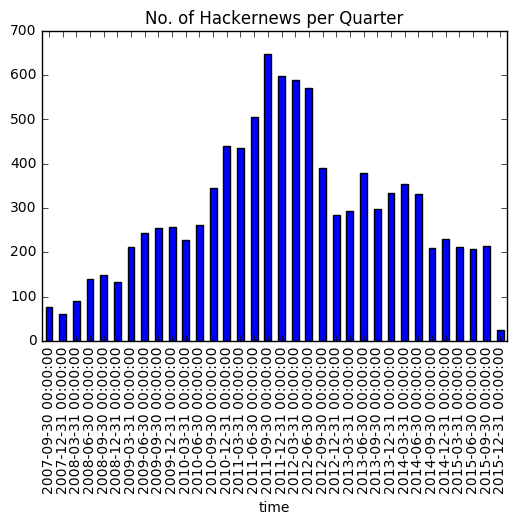

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

#which Q period has the most hackernews - split by type
bar_chart=df['id'].groupby(pd.TimeGrouper("Q")).count().plot(kind='bar', title='No. of Hackernews per Quarter')
bar_chart.x_label = 'Date'
bar_chart.y_label = 'Quantity'
fig = bar_chart.get_figure()
fig.savefig('y.png')

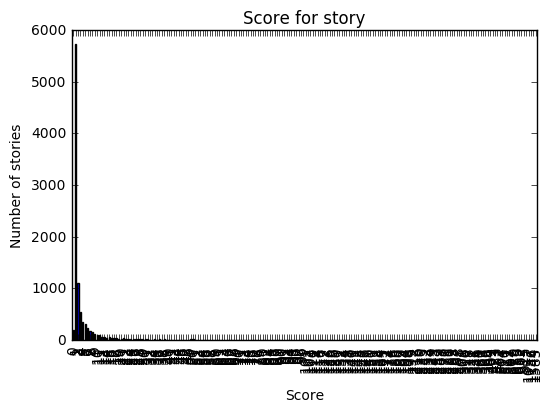

In [38]:
#groupby scores and count stories. check what is the most common score for a story
score_chart = df['id'].groupby(df['score']).count().plot(kind ='bar',title='Score for story')
score_chart.set_xlabel('Score')
score_chart.set_ylabel('Number of stories')
fig2 = score_chart.get_figure()
fig2.savefig('Score_stories.png')

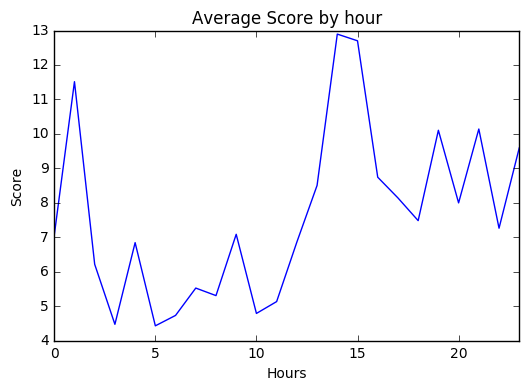

In [39]:
#which hour have the most post 
hour_chart = df['score'].groupby(df['post_hour']).mean().plot(kind ='line', title ='Average Score by hour')
hour_chart.set_xlabel('Hours')
hour_chart.set_ylabel('Score')
fig3 = hour_chart.get_figure()
fig3.savefig('hour_chart.png')

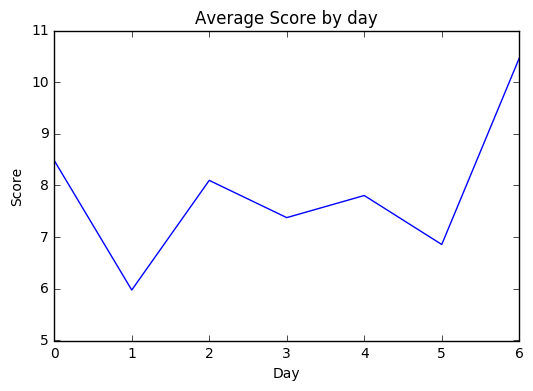

In [40]:
#which day have the most post 
day_chart = df['score'].groupby(df['post_day']).mean().plot(kind ='line', title ='Average Score by day')
day_chart.set_xlabel('Day')
day_chart.set_ylabel('Score')
fig3 = day_chart.get_figure()
fig3.savefig('day_chart.png')

In [41]:
#which authors consistently get on the front page
average_score = df['score'].groupby(df['by']).mean()
print "\n"
print 'Top 5 Authors base on mean score:' , average_score.sort_values(ascending = False).head(5) #top 5 author with highest score
print "\n"

'''
#!!! Nan for score and type...
#scatter plot score vs type
score_type = df.plot(kind = 'scatter', x = df['type_numeric'], y = df['score'], alpha = 0.2)
score_type.set_xlabel('type')
score_type.set_ylabel('score')
fig3 = score_type.get_figure()
fig3.savefig('Score_type.png')
'''



Top 5 Authors base on mean score: by
themanthatfell    1344.0
detectify         1156.0
thy_inquisitor     662.0
huhtenberg         659.0
needmoney          620.0
Name: score, dtype: float64




"\n#!!! Nan for score and type...\n#scatter plot score vs type\nscore_type = df.plot(kind = 'scatter', x = df['type_numeric'], y = df['score'], alpha = 0.2)\nscore_type.set_xlabel('type')\nscore_type.set_ylabel('score')\nfig3 = score_type.get_figure()\nfig3.savefig('Score_type.png')\n"

# Text analysis using Naive Bayes

In [ ]:
#ngram text analysis on 10000 text. 
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(ngram_range=(1,99999))
df_text = df[['score', 'text']].copy()
X = CV.fit_transform(df_text['text'])
Y = df_text['score']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, random_state =3)

def accuracy_report(_clf):
    training_accuracy = _clf.score(xtrain, ytrain)
    test_accuracy = _clf.score(xtest, ytest)
    print "Accuracy on test data: %0.2f%%" % (100 * test_accuracy)
    print "Accuracy on training data: %0.2f%%" % (100 * training_accuracy)

print '===Naive Bayes: Feature = text; Target = score.===\n'


from sklearn.naive_bayes import MultinomialNB
print "MultinomialNB:"
clf_m = MultinomialNB().fit(xtrain, ytrain)
accuracy_report(clf_m)
'''
print "\n"

from sklearn.naive_bayes import BernoulliNB
print "BernoulliNB:"
clf_b = BernoulliNB().fit(xtrain, ytrain)
accuracy_report(clf_b)

print "\n"

from sklearn.linear_model import LogisticRegression
print "Logistic Regression:"
clf_lr = LogisticRegression().fit(xtrain, ytrain)
accuracy_report(clf_lr)


#find the most common words among highest score.
'''

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
print df.info()

X = df[['deleted', 'dead', 'descendants','poll','story', 'post_hour','post_day']]
y = np.asarray(df.score, dtype ='|S6')


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)
print knn.predict([[1,0,0,0,1,10,4]])

# KFOLD

In [ ]:
from sklearn.model_selection import KFold